In [1]:
!ls

4FactorReturns_subset.csv  Assg4.ipynb	FundData.xlsx


# Step 1

In [2]:
!pip install finance-byu

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import multiprocessing
import matplotlib.pyplot as plt

In [4]:
FundData = pd.read_excel('FundData.xlsx')

In [5]:
FourFactor = pd.read_csv('4FactorReturns_subset.csv')

In [6]:
FourFactor['Date'] = pd.to_datetime(FourFactor['Date'])

In [7]:
combined = pd.merge(FundData, FourFactor, how='left', left_on='date', right_on='Date')
combined['fund_return'] = combined['fund_return'] * 100
combined['fund_ex_return'] = combined['fund_return'] - combined['RF']
combined.rename(columns={'Mkt-RF':'Mkt_RF'}, inplace=True)
combined.rename(columns={'Mom   ':'Mom'}, inplace=True)
combined.head()

,fundid,date,exp_ratio,mtna,fund_return,Date,Mkt_RF,SMB,HML,RF,Mom,fund_ex_return
0,100001,1990-03-31,0.0,109.59,1.88,1990-03-31,1.83,1.53,-2.89,0.64,1.64,1.24
1,100001,1990-04-30,0.0,109.59,-1.20,1990-04-30,-3.36,-0.49,-2.55,0.69,2.43,-1.89
2,100001,1990-05-31,0.0,109.59,8.96,1990-05-31,8.42,-2.56,-3.72,0.68,3.05,8.28
3,100001,1990-06-30,0.0,142.82,-0.17,1990-06-30,-1.09,1.42,-1.95,0.63,2.43,-0.80
4,100001,1990-07-31,0.0,142.82,0.37,1990-07-31,-1.90,-3.21,0.06,0.68,5.94,-0.31


In [8]:
# funds are added when having >= 60 months of data

combined_a = combined.groupby('fundid').filter(lambda x: x['date'].count() >= 60)

In [9]:
combined_a

,fundid,date,exp_ratio,mtna,fund_return,Date,Mkt_RF,SMB,HML,RF,Mom,fund_ex_return
0,100001,1990-03-31,0.0,109.59,1.88,1990-03-31,1.83,1.53,-2.89,0.64,1.64,1.24
1,100001,1990-04-30,0.0,109.59,-1.20,1990-04-30,-3.36,-0.49,-2.55,0.69,2.43,-1.89
2,100001,1990-05-31,0.0,109.59,8.96,1990-05-31,8.42,-2.56,-3.72,0.68,3.05,8.28
3,100001,1990-06-30,0.0,142.82,-0.17,1990-06-30,-1.09,1.42,-1.95,0.63,2.43,-0.80
4,100001,1990-07-31,0.0,142.82,0.37,1990-07-31,-1.90,-3.21,0.06,0.68,5.94,-0.31
...,...,...,...,...,...,...,...,...,...,...,...,...
1048512,501498,2019-12-31,NaN,2462.40,3.02,2019-12-31,2.77,0.71,1.93,0.14,-2.27,2.88
1048513,501498,2020-01-31,NaN,2505.50,0.35,2020-01-31,-0.11,-3.09,-6.30,0.13,5.43,0.22
1048514,501498,2020-02-29,NaN,2329.70,-8.00,2020-02-29,-8.13,1.00,-3.96,0.12,-0.23,-8.12
1048515,501498,2020-03-31,NaN,2120.40,-11.43,2020-03-31,-13.38,-5.10,-14.11,0.12,8.55,-11.55


In [10]:
fund_list = combined_a['fundid'].drop_duplicates().tolist()
date_list = combined_a['date'].drop_duplicates().tolist()

In [11]:
# the first step of Fama-Macbeth Regression, estimating betas. 

beta = np.empty((0, 5), float)
ts_residue, t_alpha, date_residue, pv = [], [], [], [] # for part 2

for i in fund_list:
    dat = combined_a.loc[combined_a['fundid'] == i]
    ts_res = smf.ols(formula='fund_ex_return ~ Mkt_RF + SMB + HML + Mom', data=dat).fit(cov_type='HAC',cov_kwds={'maxlags':3})
    beta = np.vstack((beta, np.array(ts_res.params)))
    date_residue.append(dat['date'])
    ts_residue.append(ts_res.resid)
    t_alpha.append(ts_res.tvalues[0])
    pv.append(ts_res.pvalues[0])
    

In [12]:
# betas estimation results.

reg_1 = pd.DataFrame(beta, columns=['alpha', 'beta', 'beta_smb', 'beta_hml', 'beta_mom'],
                    index=fund_list)
reg_1

,alpha,beta,beta_smb,beta_hml,beta_mom
100001,-0.159465,0.957154,-0.178973,0.077315,0.009764
100003,-0.072577,1.035649,0.373965,0.130876,0.036345
100004,-0.044925,1.029714,-0.097762,-0.219081,0.016163
100005,-0.181624,0.610209,-0.002763,0.259858,-0.083259
100006,0.065678,0.837348,-0.031528,0.277161,-0.114044
...,...,...,...,...,...
501487,-0.304190,1.223179,0.592225,0.204239,-0.068227
501492,-0.070339,0.973978,-0.044381,-0.123304,-0.005669
501493,-0.294307,1.295596,0.086564,0.054804,-0.088699
501497,0.057690,1.045217,-0.103957,-0.282955,0.021862


In [13]:
reg_1['alpha'].sort_values()

102361     -4.094530
103165     -2.952175
100219     -2.927088
216506     -2.859768
103164     -2.676014
             ...    
106434      4.191090
108886      5.680446
107967      6.107627
107968      6.123210
109389    118.185312
Name: alpha, Length: 4737, dtype: float64

In [14]:
for i in [reg_1['alpha'].idxmax()]:
    dat = combined_a.loc[combined_a['fundid'] == i]
    ts_res = smf.ols(formula='fund_ex_return ~ Mkt_RF + SMB + HML + Mom', data=dat).fit(cov_type='HAC',cov_kwds={'maxlags':3})
ts_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         fund_ex_return   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.2992
Date:                Sun, 08 Nov 2020   Prob (F-statistic):              0.878
Time:                        23:16:40   Log-Likelihood:                -672.34
No. Observations:                  79   AIC:                             1355.
Df Residuals:                      74   BIC:                             1367.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    118.1853    111.490      1.060      0.289    -100.330     336.701
Mkt_RF        35.3066     33.371      1.058      0.290     -30.100     100.713
SMB          -12.2319     16.508     -0.741      0.459     -44.587      20.123
HML          -68.0425     63.853     -1.066      0.287    -193.191      57.106
Mom           70.0024     65.480      1.069      0.285     -58.336     198.341
==============================================================================
Omnibus:                      165.436   Durbin-Watson:                   1.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16027.587
Skew:                           8.180   Prob(JB):                         0.00
Kurtosis:                      70.834   Cond. No.                         5.49
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 3 lags and without small sample correction
"""

In [15]:
# the second step of Fama-Macbeth Regression. Using 3 lags for Newey-West adjustment. 

loading2 = np.empty((0, 5), float)
stderr2 = np.empty((0, 5), float)
tstat2 = np.empty((0, 5), float)

for j in date_list:
    
    df_2 = reg_1.iloc[:,1:5].loc[combined_a.loc[combined_a['date'] == j]['fundid']]
    y = combined_a.loc[combined_a['date'] == j]['fund_ex_return']
    df_2['extr'] = np.array(y)
    
    ts_res_2_2 = smf.ols(formula='extr ~ beta + beta_smb + beta_hml + beta_mom', data=df_2).fit(cov_type='HAC',cov_kwds={'maxlags':3})
    loading2 = np.vstack((loading2, np.array(ts_res_2_2.params)))
    stderr2 = np.vstack((stderr2, np.array(ts_res_2_2.bse)))
    tstat2 = np.vstack((tstat2, np.array(ts_res_2_2.tvalues)))
    

In [16]:
# An example 2nd step of Fama-MacBeth regression

ts_res_2_2.tvalues

Intercept     3.272532
beta         30.977271
beta_smb     10.999896
beta_hml      3.554058
beta_mom      0.213600
dtype: float64

In [17]:
reg_2_2_m = pd.DataFrame(loading2, 
                    columns=['alpha_loading', 'beta_loading', 'beta_smb_loading', 'beta_hml_loading', 'beta_mom_loading'],
                    index=date_list)
reg_2_2_se = pd.DataFrame(stderr2, 
                    columns=['alpha_loading', 'beta_loading', 'beta_smb_loading', 'beta_hml_loading', 'beta_mom_loading'],
                    index=date_list)
reg_2_2_t = pd.DataFrame(tstat2, 
                    columns=['alpha_loading', 'beta_loading', 'beta_smb_loading', 'beta_hml_loading', 'beta_mom_loading'],
                    index=date_list)

In [18]:
reg_2_2_m

,alpha_loading,beta_loading,beta_smb_loading,beta_hml_loading,beta_mom_loading
1990-03-31,-1.365938,3.192963,1.122066,-2.300217,-2.152035
1990-04-30,-1.469860,-1.555745,-0.405625,-2.331893,-1.051735
1990-05-31,0.856861,7.393086,-0.068362,-2.649508,2.627656
1990-06-30,0.695861,-1.012957,0.227839,-1.909236,0.312496
1990-07-31,2.135853,-4.012408,-1.329929,1.532172,2.580791
...,...,...,...,...,...
2019-12-31,0.529542,2.278462,-0.121128,0.763799,-3.426725
2020-01-31,1.278347,-1.942878,-1.638899,-6.123310,6.280912
2020-02-29,0.624146,-8.494454,1.000264,-6.943411,-1.904128
2020-03-31,-2.757695,-11.855472,-7.490935,-14.456660,7.701602


In [19]:
reg_2_2_t

,alpha_loading,beta_loading,beta_smb_loading,beta_hml_loading,beta_mom_loading
1990-03-31,-5.743627,11.913672,3.748942,-6.929393,-2.464451
1990-04-30,-8.394388,-7.772484,-1.097743,-7.482251,-1.392729
1990-05-31,3.538329,22.806282,-0.131936,-7.202750,2.073593
1990-06-30,4.538378,-5.709678,0.845121,-8.048099,0.490208
1990-07-31,9.612566,-14.674215,-3.460222,3.479352,2.373634
...,...,...,...,...,...
2019-12-31,4.494290,16.725037,-0.956078,3.922549,-5.617721
2020-01-31,9.902495,-12.736842,-10.154895,-24.851235,8.825635
2020-02-29,3.931841,-50.013754,7.275337,-38.756875,-3.230590
2020-03-31,-10.575256,-39.939825,-32.154846,-39.237714,7.830450


In [20]:
# the final Fama-Macbeth regression result.

reg2_summary = pd.DataFrame(np.array((
    np.array(reg_2_2_m[['alpha_loading', 'beta_loading', 'beta_smb_loading', 'beta_hml_loading', 'beta_mom_loading']].mean()),
    np.array(reg_2_2_se[['alpha_loading', 'beta_loading', 'beta_smb_loading', 'beta_hml_loading', 'beta_mom_loading']].mean()))),
                           columns=['intercept','Mkt-RF','SMB','HML','Mom'], index=['mean', 'NWStderr'])
reg2_summary

,intercept,Mkt-RF,SMB,HML,Mom
mean,0.166183,0.417519,0.052088,-0.053074,0.718739
NWStderr,0.164563,0.202040,0.262318,0.322456,0.749871


# Step 2

In [21]:
# step1
# reg_1, ts_residue, t_alpha, date_residue

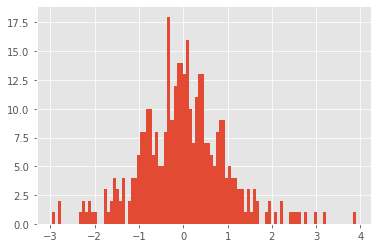

In [22]:
plt.style.use('ggplot')
plt.hist(ts_residue[0], bins=100)
plt.show()

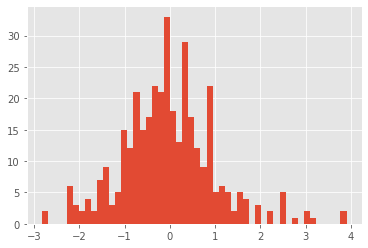

In [23]:
plt.style.use('ggplot')
plt.hist(np.random.choice(np.array(ts_residue[0]), size=len(np.array(date_residue[0]))), bins=50)
plt.show()

In [24]:
combined_a

,fundid,date,exp_ratio,mtna,fund_return,Date,Mkt_RF,SMB,HML,RF,Mom,fund_ex_return
0,100001,1990-03-31,0.0,109.59,1.88,1990-03-31,1.83,1.53,-2.89,0.64,1.64,1.24
1,100001,1990-04-30,0.0,109.59,-1.20,1990-04-30,-3.36,-0.49,-2.55,0.69,2.43,-1.89
2,100001,1990-05-31,0.0,109.59,8.96,1990-05-31,8.42,-2.56,-3.72,0.68,3.05,8.28
3,100001,1990-06-30,0.0,142.82,-0.17,1990-06-30,-1.09,1.42,-1.95,0.63,2.43,-0.80
4,100001,1990-07-31,0.0,142.82,0.37,1990-07-31,-1.90,-3.21,0.06,0.68,5.94,-0.31
...,...,...,...,...,...,...,...,...,...,...,...,...
1048512,501498,2019-12-31,NaN,2462.40,3.02,2019-12-31,2.77,0.71,1.93,0.14,-2.27,2.88
1048513,501498,2020-01-31,NaN,2505.50,0.35,2020-01-31,-0.11,-3.09,-6.30,0.13,5.43,0.22
1048514,501498,2020-02-29,NaN,2329.70,-8.00,2020-02-29,-8.13,1.00,-3.96,0.12,-0.23,-8.12
1048515,501498,2020-03-31,NaN,2120.40,-11.43,2020-03-31,-13.38,-5.10,-14.11,0.12,8.55,-11.55


In [25]:
reg_1_tableii = reg_1.copy()
reg_1_tableii['t_alpha'] = t_alpha
reg_1_tableii['pv'] = pv
reg_1_tableii.reset_index(inplace=True)
reg_1_tableii

,index,alpha,beta,beta_smb,beta_hml,beta_mom,t_alpha,pv
0,100001,-0.159465,0.957154,-0.178973,0.077315,0.009764,-2.942173,0.003259
1,100003,-0.072577,1.035649,0.373965,0.130876,0.036345,-0.581416,0.560960
2,100004,-0.044925,1.029714,-0.097762,-0.219081,0.016163,-0.629411,0.529080
3,100005,-0.181624,0.610209,-0.002763,0.259858,-0.083259,-2.199505,0.027842
4,100006,0.065678,0.837348,-0.031528,0.277161,-0.114044,0.501853,0.615771
...,...,...,...,...,...,...,...,...
4732,501487,-0.304190,1.223179,0.592225,0.204239,-0.068227,-1.338685,0.180673
4733,501492,-0.070339,0.973978,-0.044381,-0.123304,-0.005669,-1.420944,0.155333
4734,501493,-0.294307,1.295596,0.086564,0.054804,-0.088699,-0.829323,0.406922
4735,501497,0.057690,1.045217,-0.103957,-0.282955,0.021862,0.901416,0.367367


In [26]:
# Table II build

quantile_list = [.01, .03, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .97, .99]
idx = np.array(quantile_list) * (4737 - 1)
idx = (idx + 0.5).astype('int')
idx_a = list(range(5)) + idx.tolist() + list(range(4737-5,4737))

In [27]:
panelA_fund_list_rk = reg_1_tableii.sort_values(['alpha']).iloc[idx_a]['index'].index.tolist()

In [28]:
panelB_fund_list_rk = reg_1_tableii.sort_values(['t_alpha']).iloc[idx_a]['index'].index.tolist()

In [29]:
t_2_A_row1 = reg_1_tableii.sort_values(['alpha']).iloc[idx_a]['alpha'].values.tolist()
t_2_B_row1 = reg_1_tableii.sort_values(['t_alpha']).iloc[idx_a]['t_alpha'].values.tolist()

In [30]:
def part_2_b(k):
    
    '''
    Generate a 1000times a funds pseudo exrt.
    '''
    
    c_alpha, c_t = 0, 0

    for b in range(1000):
        factor_i = reg_2_2_m[reg_2_2_m.index.isin(date_residue[k])][['beta_loading','beta_smb_loading','beta_hml_loading','beta_mom_loading']].values

        y1 = np.add(factor_i.dot(reg_1.iloc[k][1:]), np.random.RandomState().choice(np.array(ts_residue[k]), size=len(np.array(date_residue[k]))))
        X = factor_i
        X = sm.add_constant(X)
        step3_res = sm.OLS(y1, X).fit(cov_type='HAC',cov_kwds={'maxlags':3})
        if step3_res.params[0] < reg_1_tableii.iloc[k]['alpha']:
            c_alpha += 1
        if step3_res.tvalues[0] < reg_1_tableii.iloc[k]['t_alpha']:
            c_t += 1
            
    return np.array((c_alpha, c_t))/1000

In [31]:
def driver_func2(ls):
    PROCESSES = 10
    with multiprocessing.Pool(PROCESSES) as pool:
        
        fidx = [(h, ) for h in ls]

        results = [pool.apply_async(part_2_b, f) for f in fidx]

        return [r.get() for r in results]

In [ ]:
%%time
a = driver_func2(panelA_fund_list_rk)

In [ ]:
%%time
b = driver_func2(panelB_fund_list_rk)

In [38]:
pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.max_columns', 25)

tableii = [t_2_A_row1, 
           pd.DataFrame(a).iloc[:13].append(1 - pd.DataFrame(a).iloc[13:]).T.values[0].tolist(),
           pd.DataFrame(a).iloc[:13].append(1 - pd.DataFrame(a).iloc[13:]).T.values[1].tolist(),
           t_2_B_row1,
           pd.DataFrame(b).iloc[:13].append(1 - pd.DataFrame(b).iloc[13:]).T.values[0].tolist(),
           pd.DataFrame(b).iloc[:13].append(1 - pd.DataFrame(b).iloc[13:]).T.values[1].tolist()]
pd.DataFrame(tableii, columns=['Bottom','2.','3.','4.','5.','1%','3%','5%','10%','20%','30%','40%',
                               'Median','40%','30%','20%','10%','5%','3%','1%','5.','4.','3.','2.','Top'],
            index=['Unconditional Alpha', 'Cross-sectionally Bootstrapped p-Value', 'Parametric p-Value',
                  't-Unconditional Alpha', 'Cross-sectionally Bootstrapped p-Value', 'Parametric p-Value'])

,Bottom,2.,3.,4.,5.,1%,3%,5%,10%,20%,30%,40%,Median,40%,30%,20%,10%,5%,3%,1%,5.,4.,3.,2.,Top
Unconditional Alpha,-4.09,-2.95,-2.93,-2.86,-2.68,-1.00,-0.65,-0.49,-0.35,-0.23,-0.16,-0.11,-0.07,-0.02,0.02,0.08,0.16,0.23,0.29,0.51,4.19,5.68,6.11,6.12,118.19
Cross-sectionally Bootstrapped p-Value,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.06,0.02,0.00,0.04,0.28,0.31,0.62,0.40,0.30,0.01,0.03,0.00,0.11,0.28,0.10,0.07,0.08,0.21
Parametric p-Value,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.07,0.09,0.01,0.06,0.28,0.28,0.61,0.40,0.31,0.05,0.05,0.01,0.02,0.09,0.09,0.06,0.07,0.07
t-Unconditional Alpha,-8.59,-8.06,-7.95,-7.83,-7.24,-3.89,-3.08,-2.73,-2.20,-1.64,-1.26,-0.88,-0.54,-0.21,0.19,0.63,1.23,1.77,2.14,2.93,4.21,4.23,4.25,5.10,5.87
Cross-sectionally Bootstrapped p-Value,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.10,0.08,0.14,0.25,0.56,0.39,0.30,0.09,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00
Parametric p-Value,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.02,0.04,0.14,0.20,0.28,0.57,0.39,0.29,0.11,0.04,0.02,0.00,0.00,0.00,0.00,0.00,0.00


# Step 3
- We jointly sample fund (and explanatory) returns, whereas Kosowski et al. (2006) do independent simulations for each fund.
- Their rules for including funds in the simulation tests are also different. They include the complete return histories of all funds that survive more than 60 months (so there is survival bias). We include funds after they pass $5 million in AUM if they have at least 8 months of returns thereafter (less survival bias).

In [58]:
combined_b = combined.loc[combined['mtna']>5]
combined_b = combined_b.groupby('fundid').filter(lambda x: x['date'].count() >= 8) # accordingly

In [59]:
dt_pt3 = combined_b.copy()
dt_pt3 = pd.merge(dt_pt3, reg_1_tableii[['index', 'alpha']], how='left', left_on='fundid', right_on='index')

In [60]:
#calculate net return&gross return
dt_pt3['gross_adj_r'] = dt_pt3['fund_ex_return'] - dt_pt3['alpha']
dt_pt3['net_adj_r'] = dt_pt3['fund_ex_return'] - dt_pt3['alpha'] - dt_pt3['exp_ratio']

In [85]:
def part_3(k):
    
    '''
    Generate a 1000times a fund's boostrapped alpha.
    '''
    
    c_alpha = []

    for b in range(1000):
        l = len(dt_pt3.loc[dt_pt3['fundid']==k])
        factor_i = reg_2_2_m.sample(n=l,replace=True, random_state=np.random.RandomState())[['beta_loading','beta_smb_loading','beta_hml_loading','beta_mom_loading']].values

        y1 = dt_pt3['net_adj_r'].sample(n=l,replace=True, random_state=np.random.RandomState()).values
        X = factor_i
        X = sm.add_constant(X)
        step3_res = sm.OLS(y1, X, missing = 'drop').fit(cov_type='HAC',cov_kwds={'maxlags':3})
        c_alpha.append(step3_res.params[0])


            
    return c_alpha

In [79]:
fund_list_p3 = dt_pt3['fundid'].drop_duplicates().tolist()

In [87]:
def driver_func3(ls):
    PROCESSES = 10
    with multiprocessing.Pool(PROCESSES) as pool:
        
        fidx = [(h, ) for h in ls]

        results = [pool.apply_async(part_3, f) for f in fidx]

        return [r.get() for r in results]

In [ ]:
%%time
a = driver_func3(fund_list_p3)
a

In [97]:
adf = pd.DataFrame(a)
adf

,0,1,2,3,4,5,6,7,8,9,10,11,...,988,989,990,991,992,993,994,995,996,997,998,999
0,0.51,0.78,0.85,0.66,0.71,0.07,0.37,0.18,0.73,0.68,0.48,0.62,...,0.03,0.64,0.43,0.28,0.14,0.30,0.27,1.30,0.59,0.39,0.18,0.88
1,0.32,0.97,0.65,0.42,0.15,0.59,0.72,0.53,0.13,0.37,0.25,0.76,...,0.33,0.06,-0.17,0.26,0.72,0.87,0.86,0.24,0.76,0.60,0.55,1.02
2,0.48,0.90,0.49,0.00,0.78,0.63,0.69,0.75,0.53,0.67,0.51,0.97,...,0.46,0.02,0.31,0.24,0.71,0.78,0.41,0.45,0.11,0.42,0.49,0.65
3,-0.29,1.38,-0.54,-0.34,-0.77,1.11,0.30,0.75,0.64,0.97,0.67,1.00,...,-0.05,0.38,1.05,0.56,0.81,0.35,0.74,0.97,1.15,0.57,0.84,0.25
4,0.22,0.18,1.11,1.41,0.92,1.04,0.87,1.18,0.56,1.26,1.58,0.76,...,0.78,0.09,0.68,1.05,0.89,1.20,0.21,0.40,0.57,1.51,-0.18,-0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5290,2.07,0.87,0.52,-0.22,2.22,2.50,0.82,-0.10,0.29,-0.08,0.79,-0.84,...,1.08,-0.22,1.16,0.95,1.43,1.62,-0.32,0.54,1.65,1.05,0.03,0.78
5291,1.15,1.20,0.33,0.72,0.77,0.31,1.48,0.26,0.90,1.33,0.75,0.86,...,0.58,0.74,0.85,0.88,-0.22,0.67,0.88,-0.15,0.64,-0.28,0.36,0.50
5292,1.39,1.04,0.70,1.37,0.81,0.99,0.12,0.74,-0.05,-0.15,0.36,0.51,...,1.30,0.68,1.15,0.84,1.28,0.23,0.31,0.77,0.65,-0.18,0.41,0.52
5293,2.04,1.05,-0.51,1.40,12.96,1.26,2.17,1.57,-2.00,-0.95,3.43,0.61,...,1.59,-1.82,1.79,1.10,-0.51,0.14,-0.60,1.74,-1.26,-0.40,2.16,1.55


In [68]:
quantile_list2 = [.01, .02, .03, .04, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .96, .97, .98, .99]

In [167]:
sim = [np.mean(adf.quantile(q,axis=1)) for q in quantile_list2]
table5_col1 = np.array(sim)

In [157]:
def Act(f_ls):
    
    # estimate actual return
    
    ls = []
    for k in f_ls:
        factor_i = reg_2_2_m[reg_2_2_m.index.isin(np.array(dt_pt3.loc[dt_pt3['fundid']==k]['date']))][['beta_loading','beta_smb_loading','beta_hml_loading','beta_mom_loading']].values

        y1 = dt_pt3.loc[dt_pt3['fundid']==k]['net_adj_r'].values
        X = factor_i
        X = sm.add_constant(X)
        try:
            step3_res = sm.OLS(y1, X, missing = 'drop').fit(cov_type='HAC',cov_kwds={'maxlags':3})
            ls.append(step3_res.params[0])
        except ValueError:  #raised if `y` is empty.
            pass

    return ls

In [ ]:
act = np.array(Act(fund_list_p3))

In [168]:
table5_col2 = np.quantile(act, quantile_list2)

In [173]:
per_act = np.array([np.sum(adf.iloc[i] < act[i])/1000 for i in range(4575)])
table5_col3 = np.quantile(per_act, quantile_list2)*100

In [175]:
table5 = pd.DataFrame([table5_col1,table5_col2,table5_col3]).T
table5.columns=['Sim','Act','%<Act']
table5.index = quantile_list2
table5

,Sim,Act,%<Act
0.01,-0.71,-0.42,0.60
0.02,-0.54,-0.26,2.15
0.03,-0.44,-0.18,3.30
0.04,-0.37,-0.13,4.30
0.05,-0.31,-0.08,5.20
0.10,-0.11,0.01,8.60
0.20,0.11,0.10,14.10
0.30,0.27,0.17,18.20
0.40,0.41,0.21,21.70
0.50,0.53,0.25,25.10
